<a href="https://colab.research.google.com/github/dphi-official/Bootcamp-de-sur-la-Science-des-donn-es/blob/master/Semaine%202/introduction%20aux%20classes%20d%C3%A9s%C3%A9quilibr%C3%A9es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
L'ensemble de données utilisé dans ce cahier est de «[IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/data)». Ce cahier vous présentera le problème de déséquilibre de classe.

Lien de l'ensemble de données: [Fraud Dataset](https://drive.google.com/file/d/1q8SYcjOJULdSkETv5S_gd7xNq1GrBHAO/view)

#### Problème déséquilibré
Les classes déséquilibrées sont un problème courant dans la classification de l'apprentissage automatique où il existe un ratio disproportionné d'observations dans chaque classe. Le déséquilibre de classe peut être trouvé dans de nombreux domaines différents, notamment le diagnostic médical, le filtrage des spams et la détection des fraudes.

#### Agenda
* Chargement des bibliothèques
*  Chargement des données
* Obtenir une idée de base sur les données
* Valeurs manquantes et traitement des valeurs manquantes
* Un encodage à chaud (création de mannequins pour les colonnes catégorielles)
* Standardisation / Normalisation
* Diviser l'ensemble de données en données de train et de test
* Traitement des données déséquilibrées
    * Techniques de rééchantillonnage - Suréchantillonner la classe minoritaire
    * Techniques de rééchantillonnage - Classe majoritaire sous-échantillonnée
    * Générer des échantillons synthétiques

## Chargement des bibliothèques
Toutes les fonctionnalités Python ne sont pas chargées dans notre environnement de travail par défaut (même si elles sont déjà installées dans votre système). Ainsi, nous importons chaque bibliothèque que nous voulons utiliser.

En science des données, numpy et pandas sont les bibliothèques les plus couramment utilisées. Numpy est nécessaire pour les calculs tels que les moyennes, les médianes, les racines carrées, etc. Pandas est utilisé pour le traitement des données et les trames de données. Nous avons choisi des noms d'alias pour nos bibliothèques par souci de commodité (numpy -> np et pandas -> pd).

In [1]:
import pandas as pd                  # A fundamental package for linear algebra and multidimensional arrays
import numpy as np                   # Data analysis and data manipulating tool
import random                        # Library to generate random numbers
from collections import Counter      # Collection is a Python module that implements specialized container datatypes providing 
                                     # alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.
                                     # Counter is a dict subclass for counting hashable objects
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# To ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

## Chargement des données
Le module Pandas est utilisé pour lire les fichiers. Nous avons nos données au format «.csv». Nous utiliserons la fonction 'read_csv ()' pour charger les données.

**Avertissement:** Le chargement des données de fraude prendra du temps.

In [4]:
fraud_data = pd.read_csv("/content/drive/My Drive/Datasets/fraud_data.csv")

### Obtenir une idée de base sur les données

In [5]:
fraud_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2994681,0,242834,25.000,H,9803,583.0,150.0,visa,226.0,credit,269.0,87.0,NaN,NaN,yahoo.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.791666,0.791666,...,0.0,82050.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,NaN,529.0,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10.12,firefox 56.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,rv:56.0
1,3557242,0,15123000,117.000,W,7919,194.0,150.0,mastercard,166.0,debit,181.0,87.0,483.0,NaN,gmail.com,NaN,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,35.0,1.0,4.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3327470,0,8378575,73.773,C,12778,500.0,185.0,mastercard,224.0,credit,284.0,60.0,NaN,NaN,hotmail.com,hotmail.com,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,54.0,35.0,54.0,35.0,54.0,35.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3118781,0,2607840,400.000,R,12316,548.0,150.0,visa,195.0,credit,441.0,87.0,NaN,371.0,anonymous.com,anonymous.com,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,183599.0,NaN,NaN,6.0,-11.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,15.0,352.0,280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 10.3.3,mobile safari generic,32.0,1136x640,match_status:2,T,F,T,F,mobile,iOS Device
4,3459772,0,12226544,31.950,W,9002,453.0,150.0,visa,226.0,debit,264.0,87.0,10.0,NaN,yahoo.com,NaN,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,54.0,15.0,405.0,32.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
fraud_data.info()      # Returns a concise summary of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59054 entries, 0 to 59053
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(385), int64(18), object(31)
memory usage: 195.5+ MB


Il y a 434 colonnes avec 59054 observations.

In [7]:
# Taking a look at the target variable
fraud_data.isFraud.value_counts()       # The value_counts() function is used to get a Series containing counts of unique values.

0    57049
1     2005
Name: isFraud, dtype: int64

Nous pouvons remarquer que sur 57049 observations / enregistrements, seuls 2005 étaient des opérations de fraude.

In [8]:
fraud_data.isFraud.value_counts() / len(fraud_data) * 100       # Gets the percentage of unique values in the variable 'isFraud'

0    96.604802
1     3.395198
Name: isFraud, dtype: float64

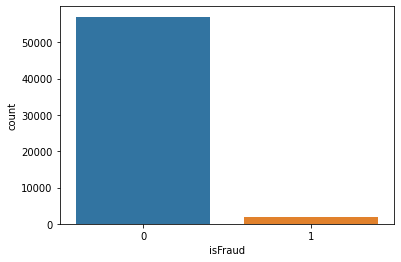

In [9]:
# we can also use countplot form seaborn to plot the above information graphically.
sns.countplot(fraud_data.isFraud)

Il n'y a que 3% des données qui sont des fraudes et les 97% restants ne sont pas des fraudes. Il s'agit clairement d'un problème de déséquilibre de classe. Dans ce cahier, nous chercherons à résoudre ce type de problèmes.

### Valeurs manquantes
En général, les ensembles de données ont toujours des valeurs manquantes. Peut être effectué lors de la collecte de données ou en raison d'une règle de validation des données.

In [10]:
fraud_data.isnull().sum() / len(fraud_data) * 100   # To get percentage of missing data in each column

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
                    ...    
id_36             75.945745
id_37             75.945745
id_38             75.945745
DeviceType        75.979612
DeviceInfo        79.813391
Length: 434, dtype: float64

Sur 434 colonnes, 414 ont des valeurs manquantes.

### Traiter les valeurs manquantes
* Remplir les valeurs manquantes avec la bonne technique peut changer radicalement nos résultats.
* De plus, il n'y a pas de règle fixe pour remplir les valeurs manquantes.
* Aucune méthode n'est parfaite pour remplir les valeurs manquantes. Nous devons utiliser notre bon sens, notre logique, ou peut-être avoir besoin de voir ce qui fonctionne pour cet ensemble de données particulier.

### Moyens de gérer les valeurs manquantes:

**Valeur par défaut:** On peut remplir la valeur manquante par valeur par défaut sur la base de 1) compréhension de la variable, 2) aperçu du contexte / données ou 3) bon sens / logique.

**Suppression:** Supposons que dans notre ensemble de données, nous ayons trop de valeurs manquantes dans

* Colonne, nous pouvons déposer la colonne
* Ligne, laisse tomber la ligne. Habituellement, nous faisons cela pour un ensemble de données suffisamment grand.

**Moyenne / Médiane / Mode - Imputation:** Nous remplissons les valeurs manquantes par la moyenne, la médiane ou le mode (c'est-à-dire la valeur maximale actuelle). En général, nous utilisons la moyenne, mais s'il y a des valeurs aberrantes, nous remplissons les valeurs manquantes avec la médiane. Le mode est utilisé pour remplir les valeurs manquantes pour la colonne catégorielle.

[Nettoyage des données en Python: le guide ultime](https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d)

Éliminez les colonnes avec plus de 20% de valeurs manquantes. Encore une fois, cela est très subjectif et dépend uniquement de la nature de l'ensemble de données et du contexte sous-jacent. Nous ne pouvons pas généraliser cette procédure à tous les ensembles de données.

In [11]:
fraud_data = fraud_data[fraud_data.columns[fraud_data.isnull().mean() < 0.2]]    # Will keep those columns which has missing values less than 20%

Ici, nous allons remplir les valeurs manquantes des variables numériques (ou colonnes) avec la valeur moyenne.

**Les variables ne sont rien d'autre que les noms de colonnes. À partir de là, nous commencerons à utiliser les variables au lieu des noms de colonnes ou de colonnes.**

In [12]:
# filling missing values of numerical columns with mean value.
num_cols = fraud_data.select_dtypes(include=np.number).columns      # getting all the numerical columns

fraud_data[num_cols] = fraud_data[num_cols].fillna(fraud_data[num_cols].mean())   # fills the missing values with mean

Remplir les valeurs manquantes des variables catégorielles avec mode.
Pour ceux qui ne sont pas surveillés, le mode est l'élément maximal d'une variable.

Pourquoi le mode pour les variables catégorielles? - Prenons un exemple de variable catégorielle: «Statut social» avec des valeurs: (Pauvre, Niveau de revenu intermédiaire, Riche). Pouvons-nous trouver un moyen de satus social? Non! Donc, il n'est peut-être pas significatif d'aller avec la moyenne dans ce cas car ce n'est pas valide.

In [ ]:
cat_cols = fraud_data.select_dtypes(include = 'object').columns    # getting all the categorical columns

fraud_data[cat_cols] = fraud_data[cat_cols].fillna(fraud_data[cat_cols].mode().iloc[0])  # fills the missing values with maximum occuring element in the column

"""
Explaining above line: (This explanation was given by Julilan Miranda in a group)

The above line of code is replacing the missing values in the columns in cat_cols with the mode (most repeated elements) of the non-missing values 
in the same columns.
The .iloc[0] attribute is selecting just the first mode returned, in case they are multiple values with the same highest frequency of occurrence. 
Please review the documentation for further clarifications on this regard: 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mode.html
"""

In [16]:
# Let's have a look if there still exist any missing values
fraud_data.isnull().sum() / len(fraud_data) * 100

TransactionID     0.0
isFraud           0.0
TransactionDT     0.0
TransactionAmt    0.0
ProductCD         0.0
                 ... 
V317              0.0
V318              0.0
V319              0.0
V320              0.0
V321              0.0
Length: 182, dtype: float64

Remarquez, maintenant nous n'avons aucune colonne avec une valeur manquante.

### One Hot Encoding (Création de mannequins pour les colonnes catégorielles)
Dans cette stratégie, chaque valeur de catégorie est convertie en une nouvelle colonne et attribuée une valeur 1 ou 0 (notation pour vrai / faux) à la colonne. En Python, il y a une classe 'OneHotEncoder' dans 'sklearn.preprocessing' pour faire cette tâche, mais ici nous utiliserons la fonction pandas 'get_dummies ()'. Ce get_dummies () fait le même travail que celui effectué par le formulaire «OneHotEncoder» sklearn.preprocessing.

![alt text](https://dphi.tech/blog/wp-content/uploads/2020/06/ohe.png)

[Why One-Hot Encode Data in Machine Learning?](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [ ]:
fraud_data = pd.get_dummies(fraud_data, columns=cat_cols)    # earlier we have collected all the categorical columns in cat_cols

In [24]:
fraud_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,...,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,2994681,0,242834,25.000,9803,583.0,150.0,226.0,269.0,87.0,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,0.135394,1.035702,1.058825,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,3557242,0,15123000,117.000,7919,194.0,150.0,166.0,181.0,87.0,1,4,0,0,0,1,0,0,3,0,3,0,4,1,63.0,4.000000,4.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3327470,0,8378575,73.773,12778,500.0,185.0,224.0,284.0,60.0,1,3,0,1,0,1,1,0,0,0,2,2,3,1,54.0,0.000000,54.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3118781,0,2607840,400.000,12316,548.0,150.0,195.0,441.0,87.0,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,124.267325,163.966616,0.55965,0.597624,0.999398,0.124619,0.125551,0.137374,0.13883,0.814731,0.845542,0.133239,0.135394,1.035702,1.058825,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3459772,0,12226544,31.950,9002,453.0,150.0,226.0,264.0,87.0,3,3,0,0,3,4,0,0,3,0,2,0,33,3,54.0,71.000000,620.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Si vous remarquez, de nombreuses variables factices sont créées comme; **P_emaildomain_hotmail.com, P_emaildomain_hotmail.de,** etc.

#### Fonctions d'entrée et fonctions de sortie séparées

In [25]:
# Separate input features and output feature
X = fraud_data.drop(columns = ['isFraud'])       # input features
Y = fraud_data.isFraud      # output feature

### Standardisation / Normalisation
Les variables d'un ensemble de données réel sont souvent accompagnées d'un large éventail de valeurs de données.

Par exemple, si vous regardez cet ensemble de données sur la fraude, la variable «TransactionAmt» a des valeurs comprises entre 0,292 et 5279,95, tandis que si vous regardez la variable «V14», elle a des valeurs comprises entre 0,0 et 1,0. Fondamentalement, ils ne sont pas sur une échelle commune.

**Maintenant, comment la normalisation / normalisation aide-t-elle?**

La normalisation / normalisation amènerait toutes les variables d'un ensemble de données à une échelle commune afin de contribuer davantage à la mise en œuvre de divers modèles d'apprentissage automatique (où la normalisation / normalisation est une condition préalable à l'application de tels modèles). Encore une fois, ne prenez pas cela pour acquis, il existe des algorithmes intelligents qui n'en ont pas besoin et qui exploreront l'un d'entre eux ici.

Eh bien, nous avons également discuté de la standardisation / normalisation dans le matériel d'étude **Semaine # 2 - Jour # 1**.

Ici, nous utiliserons la classe «StandardScaler» de «sklearn.preprocessing» pour mettre à l'échelle nos données.

![alt text](https://dphi.tech/blog/wp-content/uploads/2020/06/sn.png)

In [26]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(X)
scaled_features = pd.DataFrame(data=scaled_features)
scaled_features.columns= X.columns

In [27]:
# Let's see how the data looks after scaling
scaled_features.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,...,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
0,-1.688548,-1.544958,-0.468203,-0.021940,1.412632,-0.286861,0.653753,-0.225982,0.077832,-0.099186,-0.092969,-0.034155,-0.057671,-0.214317,-0.113785,-0.043835,-0.040593,-0.266499,-0.041472,-0.098587,-0.044784,-0.246816,-0.149534,-0.598309,-8.312926e-17,-1.524289e-16,-2.328077e-16,0.000000,-4.847131e-15,0.000000,0.000000,8.149510e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.454269e-16,...,-0.288310,-0.01164,-0.023646,-0.023285,-0.103676,-0.018406,-0.070735,-0.037289,-0.01164,-0.025707,-0.031891,-0.050125,-0.083819,-0.020987,-0.017461,-0.038411,-0.09194,-0.024698,-0.01594,-0.010888,-0.01164,-0.02058,-0.02058,-0.030532,-0.071337,-0.019305,-0.009202,-0.017461,-0.022166,-0.068774,-0.021387,-0.022918,-0.009202,-0.004115,2.216281,-0.053413,-0.013649,-0.014839,-0.015399,-0.06253
1,1.615662,1.681426,-0.073540,-0.406928,-1.078794,-0.286861,-0.804662,-1.144356,0.077832,-0.099186,-0.071893,-0.034155,-0.057671,-0.214317,-0.113785,-0.043835,-0.052023,-0.085706,-0.052858,-0.075654,-0.044784,-0.222665,-0.149534,-0.198351,-7.035279e-01,-8.579195e-01,9.233902e-01,0.808959,2.627563e-02,-0.399959,-0.396568,-4.033536e-01,-0.399817,0.467841,0.365554,-0.415703,-0.405681,-0.150184,-0.204178,1.322761e-01,...,-0.288310,-0.01164,-0.023646,-0.023285,-0.103676,-0.018406,-0.070735,-0.037289,-0.01164,-0.025707,-0.031891,-0.050125,-0.083819,-0.020987,-0.017461,-0.038411,-0.09194,-0.024698,-0.01594,-0.010888,-0.01164,-0.02058,-0.02058,-0.030532,-0.071337,-0.019305,-0.009202,-0.017461,-0.022166,-0.068774,-0.021387,-0.022918,-0.009202,-0.004115,-0.451206,-0.053413,-0.013649,-0.014839,-0.015399,-0.06253
2,0.266093,0.219070,-0.258976,0.585989,0.881042,2.788641,0.605139,-0.069441,-10.788933,-0.099186,-0.078918,-0.034155,-0.041973,-0.214317,-0.113785,-0.026137,-0.052023,-0.266499,-0.052858,-0.087120,-0.019564,-0.230715,-0.149534,-0.255488,-7.269267e-01,-5.897637e-01,-1.173555e+00,-1.201496,2.627563e-02,2.809494,2.762058,-4.033536e-01,-0.399817,0.467841,0.365554,-0.415703,-0.405681,-0.150184,-0.204178,1.322761e-01,...,3.468494,-0.01164,-0.023646,-0.023285,-0.103676,-0.018406,-0.070735,-0.037289,-0.01164,-0.025707,-0.031891,-0.050125,-0.083819,-0.020987,-0.017461,-0.038411,-0.09194,-0.024698,-0.01594,-0.010888,-0.01164,-0.02058,-0.02058,-0.030532,-0.071337,-0.019305,-0.009202,-0.017461,-0.022166,-0.068774,-0.021387,-0.022918,-0.009202,-0.004115,-0.451206,-0.053413,-0.013649,-0.014839,-0.015399,-0.06253
3,-0.959645,-1.032167,1.140478,0.491581,1.188468,-0.286861,-0.099761,1.569022,0.077832,-0.099186,-0.092969,-0.034155,-0.041973,-0.214317,-0.113785,-0.043835,-0.040593,-0.266499,-0.041472,-0.098587,-0.044784,-0.246816,-0.149534,-0.598309,-8.312926e-17,-1.524289e-16,-2.328077e-16,0.000000,-4.847131e-15,0.000000,0.000000,8.149510e-17,0.000000,0.000000,0.000000,0.000000,

### Diviser l'ensemble de données en données de train et de test
**Pourquoi diviser les données en ensembles de test et ensembles de formation?**

L'objectif du fractionnement des données dans les différentes catégories est d'éviter le surajustement.
Veuillez parcourir cette explication géniale, cela ne prendra que deux minutes pour la parcourir.

[Dans l'apprentissage automatique, quel est le but de la division des données en ensembles de tests et ensembles de formation?](Https://www.quora.com/In-machine-learning-what-s-the-purpose-of-splitting-dat-up-into-test-sets-and-training-sets)

**Qu'est-ce que le partage Train / Test?**
Les données que nous utilisons sont divisées en données d'entraînement et données de test. L'ensemble d'apprentissage contient une sortie connue et le modèle apprend sur ces données afin d'être généralisé à d'autres données ultérieurement. Nous avons le jeu de données de test (ou sous-ensemble) afin de tester la prédiction de notre modèle sur ce sous-ensemble.

! [texte alt](https://lh3.googleusercontent.com/7T5aRDAlcsyt1p4R9qMrSznpgrEu5g2q8PkS-Jnh96fxfXP-ld3G-zCt1LfnpK3sOEdkbqLXyzjlQIth1VJFc)

**Lectures complémentaires:** [Train / Test Split and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6#:~:text=Former%2FTest%20Split,à%20other%20data%20later%20on.&Text=Pandas%20%E2%80%94%20to%20load%20the%20data,frame%20and%20analyze%20the%20data.)



Nous conserverons 30% des données pour l'ensemble de test.

In [28]:
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

# X_train: independent feature data for training the model
# Y_train: dependent feature data for training the model
# X_test: independent feature data for testing the model; will be used to predict the target values
# Y_test: original target values of X_test; We will compare this values with our predicted values.
 
# test_size = 0.3: 30% of the data will go for test set and 70% of the data will go for train set
# random_state = 42: this will fix the split i.e. there will be same split for each time you run the code

# Traitement des données déséquilibrées
La plupart des algorithmes d'apprentissage automatique fonctionnent mieux lorsque le nombre d'échantillons dans chaque classe est à peu près égal. En effet, la plupart des algorithmes sont conçus pour maximiser la précision et réduire les erreurs. Encore une fois, cela ne peut pas être généralisé et nous devons être très spécifiques au cas en fonction de la nature des données et de leur contexte sous-jacent.

[Traitement des données déséquilibrées](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

## Différentes techniques
1. **Techniques de rééchantillonnage - Suréchantillonnage de la classe minoritaire:** Le suréchantillonnage peut être défini comme l'ajout de copies supplémentaires de la classe minoritaire. En d'autres termes, nous créons des données artificielles / synthétiques de la classe (ou du groupe) minoritaire. Le suréchantillonnage peut être un bon choix lorsque vous ne disposez pas de beaucoup de données avec lesquelles travailler.

Nous utiliserons le module de rééchantillonnage de la bibliothèque Scikit-Learn pour créer au hasard des échantillons artificiels de données de la classe minoritaire.

**Note importante**

AVANT d'essayer des techniques de suréchantillonnage **,vous devez** diviser vos données en ensembles de données de train et de test!

Pourquoi cela devrait-il être fait? Le suréchantillonnage avant de fractionner les données peut permettre aux mêmes observations d'être présentes à la fois dans les ensembles de test et de train. Cela peut permettre à notre modèle de simplement mémoriser des points de données spécifiques et entraîner un surajustement et une mauvaise généralisation des données de test.

In [29]:
# 'resample' is located under sklearn.utils
from sklearn.utils import resample

In [30]:
# concatenate training data back together
train_data = pd.concat([X_train, Y_train], axis = 1)

In [31]:
# separate minority and majority class
not_fraud = train_data[train_data.isFraud==0]
fraud = train_data[train_data.isFraud==1]

In [32]:
# Unsample minority; we are oversampling the minority class to match the number of majority classs
fraud_upsampled = resample(fraud,
                           replace = True, # Sample with replacement
                           n_samples = len(not_fraud), # Match number in majority class
                           random_state=27)

In [33]:
# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

In [34]:
# Now let's check the classes count
upsampled.isFraud.value_counts()

1    39942
0    39942
Name: isFraud, dtype: int64

Nous pouvons remarquer ici qu'après rééchantillonnage, nous avons un rapport égal de points de données pour chaque classe!

2. **Techniques de rééchantillonnage - Sous-échantillonnage de la classe majoritaire:** Le sous-échantillonnage peut être défini comme la suppression de certaines observations de la classe majoritaire. Le sous-échantillonnage peut être un bon choix lorsque vous avez une tonne de données - pensez à des millions de lignes. Mais un inconvénient est que nous supprimons les informations qui peuvent être précieuses. Cela pourrait conduire à un sous-ajustement et à une mauvaise généralisation de l'ensemble de test.

Nous utiliserons à nouveau le module de rééchantillonnage de Scikit-Learn pour supprimer aléatoirement des échantillons de la classe majoritaire.

In [35]:
# we are still using our separated class i.e. fraud and not_fraud from above
# Again we are removing the observations of the majority class to mathch the number of minority class
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27)

In [36]:
# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])    # Concatenation

In [37]:
# let's check the classes counts
downsampled.isFraud.value_counts()

1    1395
0    1395
Name: isFraud, dtype: int64

Encore une fois, nous avons un ratio égal de points de données sur la fraude et non sur la fraude, mais dans ce cas, une quantité beaucoup plus petite de données sur laquelle former le modèle.

3. **Générer des échantillons synthétiques:** Ici, nous utiliserons la technique de suréchantillonnage SMOTE ou de minorité synthétique d'imblearn. SMOTE utilise un algorithme de voisins les plus proches pour générer des données nouvelles et synthétiques que nous pouvons utiliser pour entraîner notre modèle.

Encore une fois, il est important de générer les nouveaux échantillons uniquement dans l'ensemble de formation pour garantir que notre modèle se généralise bien aux données invisibles.

In [38]:
# import SMOTE 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 25, ratio = 1.0)   # again we are eqalizing both the classes

In [39]:
# fit the sampling
X_train, Y_train = sm.fit_sample(X_train, Y_train)

In [40]:
np.unique(Y_train, return_counts=True)     # Y_train is numpy array, so unique() functions returns the count of all the unique elements in the array

(array([0, 1]), array([39942, 39942]))

Le nombre des deux classes est égal.

## Conclusion
C'est tout pour ce cahier. Nous avons appris à gérer les valeurs manquantes, un encodage à chaud, la standardisation / normalisation, ce qu'est une classe déséquilibrée et trois techniques pour gérer les classes déséquilibrées.

**Remarque:** Je n'ai pas couvert la partie de la construction de modèles ici mais nous aurons bientôt une session sur '**Construire votre premier modèle d'apprentissage automatique**' par **Chanukya Patnaik**.

# Merci d'avoir lu le cahier! J'espère que vous en avez profité.

Références:
1. [Dealing with Imbalanced Data by Tara Boyle](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
2. [Data Pre-processing - Handling missing values and dealing with class imbalance by Bharat Ram Ammu](https://www.youtube.com/watch?v=vksQx1JNo8Y)
